In [ ]:
#Now unlock the robot:
#await node.unlock()

In [ ]:
## How to set robot variables
rt.stop()
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
await node.set_variables(v)


# Test run of whole project

In [1]:
%run src\project\Global_nav.py
%run src\project\DetectionFcts.py
%run src\project\Locomotion.py

In [2]:
# import tdmclient.notebook
# await tdmclient.notebook.start()

In [3]:
#%%run_python

#v =[0,0]
#leds_prox_v = v
# "leds.prox.v": [0,0]
#node.send_set_variables("leds.prox.v")

In [4]:
# await tdmclient.notebook.stop()

In [5]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node b574b411-d198-49ad-8a3f-f34121cb2efa

In [6]:
def main(checkpoints_data,m, contours, area_max, Q, R, Ts, webcam) :
    global current_checkpoint_index, fsm_state, cam_available, cam_data, x_est_prev, P_est_prev, reached_end
    # we can remove cam_data and cam_available once everything is integrated
    """
    Main function which coordinates the whole application
    
    global : takes the variables that will be changed throughout the application
    
    param checkpoints_data: velocity of left wheel as decided by control law in metric [mm/s]
    param Q: Q matrix for the Kalman Filter
    param R: R matrix for the Kalman Filter
    param Ts: Period for the Python thread which uses the main(...) function
    
    no return 
    """
    if webcam:
        success,img = cap.read()
        cam_available = True
    else: 
        cam_available = False
        #img=cv2.imread(path)
    
    if cam_available:
        Thymio_coord, Thymio_found = analyse_thymio(img,contours, area_max)
        
    #rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # this converts it into RGB
    #plt.figure(figsize=(7,7))
    #plt.imshow(rgb_img)
    #plt.show()
    if (Thymio_found):
        Thymio_pos = np.array([Thymio_coord[0]*m.ratio_total, Thymio_coord[1]*m.ratio_total,Thymio_coord[2]])
        # print (Thymio_pos)
    else:
        Thymio_pos = np.array([0,0,0])
    
    sensor_data = np.array(node.v.prox.horizontal[0:5]) #get data from horiz proximity sensors
    
    [left_velocity, right_velocity, fsm_state, current_checkpoint_index] = control_law(sensor_data, checkpoints_data, current_checkpoint_index, fsm_state, x_est_prev, Thymio_found)
    #! need to add to control law input : cam available
    
    speed = [left_velocity, right_velocity]
    
    [x_est_prev, P_est_prev] = kalman_filter(speed, Thymio_found, Thymio_pos, x_est_prev, P_est_prev, Q, R, Ts)
    
    node.send_set_variables(motors(left_velocity, right_velocity))

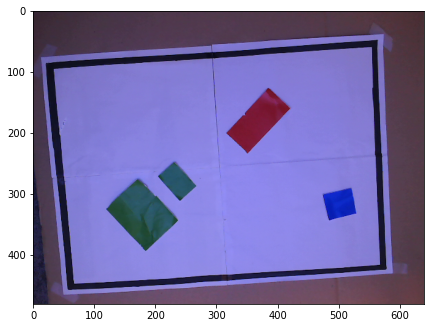

Bonne image ? : (press enter)n


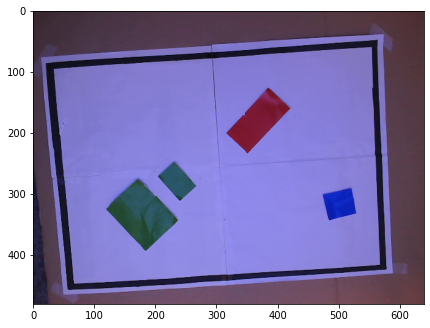

Bonne image ? : (press enter)n


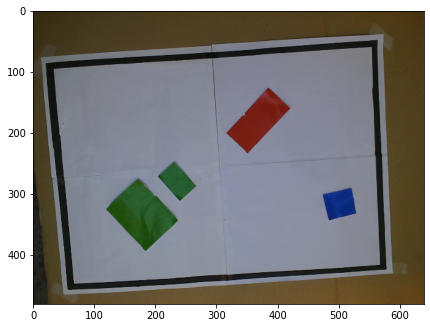

Bonne image ? : (press enter)y


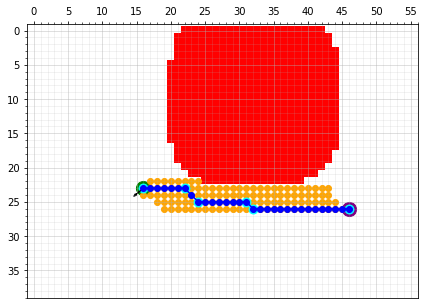

Bonne analyse ? : (press enter)y
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found
Thymio not found


In [ ]:
import os
import sys
import math
from statistics import mean
import numpy as np
import cv2
# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline


# Camera intialisation
webcam = True
# path = 'edgeDetect3.jpg'

cap = cv2.VideoCapture(1)
cap.open(1, cv2.CAP_DSHOW)

# While loop to get a proper first image
while True:
    if webcam:
        success,img = cap.read()
        plt.figure(figsize=(7, 7))
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
        plt.show()
        
    k = input("Bonne image ? : (press enter)")
    #input() waits for a user input
    if k =="y":
        m, contours, area_max = analyse(img)
        k2 = input("Bonne analyse ? : (press enter)")
        if k2 =="y":
            break

### Control Law parameters
checkpoints_data = np.array([[400, 0], [400, 400], [0, 0]])
checkpoints_data = m.checkpoints.transpose()*m.ratio_total #in mm
current_checkpoint_index = 0
fsm_state = "starting"
left_velocity = 0
right_velocity = 0 

### Kalman filter parameters
x_init = np.array([0, 0, math.pi/2])
x_init = np.array([m.start[0]*m.ratio_total,m.start[1]*m.ratio_total,m.start[2]])
P_init = np.array([0, 0, 0])


x_est_prev = x_init #state_kalman
P_est_prev = P_init

Q = np.diag([10**(-9), 10**(-9), 10**(-9)])
R = np.diag([10**(-6), 10**(-6),10**(-6)])

#! we can remove cam_data and cam_available once everything is integrated
#cam_available = False
#cam_data = [0,0,0]

### End of application bool
reached_end = False

### Thread parameter
Ts = 1

rt = RepeatedTimer(Ts, main, checkpoints_data,m, contours, area_max, Q, R, Ts, webcam) # it auto-starts, no need of rt.start()   

try:
    while not(reached_end) : 
        await node.wait_for_variables() # wait for Thymio variables values
        await client.sleep(0.1)
finally:
    rt.stop() # better in a try/finally block to make sure the program ends!
    #node.send_set_variables(motors(0, 0))
    print('Application is finished, bye bye !')


In [ ]:
#m, contours, area_max = analyse(img)
import time 
start_timer1 = time.time()
##### Put testing functions here ####
success,img = cap.read()
Thymio_coord, Thymio_found = analyse_thymio(img,contours, area_max)
Thymio_pos = (Thymio_coord[0]*m.ratio_total, Thymio_coord[1]*m.ratio_total,Thymio_coord[2])
print (Thymio_pos)
#########################################################
end_timer1 = time.time()
print(f"Runtime of the program is {end_timer1 - start_timer1}")